In [1]:
#pip install --upgrade matplotlib

In [2]:
import os
import sys
from sklearn.model_selection import train_test_split
import shutil

sys.path.append(os.path.abspath(os.path.join('..', 'modules')))

from spectrogram import create_spectrogram_dataset
from model import train_model, evaluate_model, fine_tune_model
from utils import count_images_per_class, predict_sample, plot_confusion_matrix, plot_training_history


2025-05-18 21:59:22.711845: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 21:59:22.756033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 21:59:23.507421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# ====================
# Configuration
# ====================

# Paths
BASE_SAMPLES_PATH = '../data/samples'
SPECTROGRAMS_PATH = '../out/transfer/spectrogram'
MODEL_PATH = '../out/transfer/model'
TRAIN_PATH = os.path.join(MODEL_PATH, 'train')
VAL_PATH = os.path.join(MODEL_PATH, 'val')
TEST_PATH = os.path.join(MODEL_PATH, 'test')

# Create necessary directories
for path in [SPECTROGRAMS_PATH, MODEL_PATH, TRAIN_PATH, VAL_PATH, TEST_PATH]:
    os.makedirs(path, exist_ok=True)

In [4]:
# ====================
# Create Spectrograms
# ====================

print("Converting audio samples to spectrograms...")
metadata = create_spectrogram_dataset(BASE_SAMPLES_PATH, SPECTROGRAMS_PATH)

# ====================
# Split Dataset
# ====================

print("Splitting data into train, validation, and test sets...")

for drum_type in os.listdir(SPECTROGRAMS_PATH):
    drum_path = os.path.join(SPECTROGRAMS_PATH, drum_type)

    if not os.path.isdir(drum_path) or drum_type in ['train', 'val', 'test', 'metadata.csv']:
        continue

    # Create class folders in each split
    for split_path in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
        os.makedirs(os.path.join(split_path, drum_type), exist_ok=True)

    spec_files = [f for f in os.listdir(drum_path) if f.endswith('.png')]
    print(f"Found {len(spec_files)} files for {drum_type}")

    train_files, temp_files = train_test_split(spec_files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for file, destination in zip([train_files, val_files, test_files],
                                 [TRAIN_PATH, VAL_PATH, TEST_PATH]):
        for f in file:
            src = os.path.join(drum_path, f)
            dst = os.path.join(destination, drum_type, f)
            shutil.copy2(src, dst)

# ====================
# Train Model
# ====================

print("== Training the model ==")
model, history, class_indices = train_model(TRAIN_PATH, VAL_PATH, epochs=50)

# ====================
# Evaluate Model
# ====================

print("== Evaluating the model ==")
#test_acc, predictions, true_classes = evaluate_model(model, TEST_PATH, class_indices)
test_acc, predictions, true_classes = evaluate_model(model, TEST_PATH)

# ====================
# Fine-Tune Model
# ====================

print("== Fine-tuning the model ==")
fine_tuned_model, ft_history = fine_tune_model(model, TRAIN_PATH, VAL_PATH)

# ====================
# Evaluate Fine-Tuned Model
# ====================

print("== Evaluating the fine-tuned model ==")
#ft_test_acc, ft_predictions, ft_true_classes = evaluate_model(fine_tuned_model, TEST_PATH, class_indices)
ft_test_acc, ft_predictions, ft_true_classes = evaluate_model(fine_tuned_model, TEST_PATH)

# ====================
# Class Counts
# ====================

print("Train:", count_images_per_class(TRAIN_PATH))
print("Val:", count_images_per_class(VAL_PATH))
print("Test:", count_images_per_class(TEST_PATH))

print("Done!")


Converting audio samples to spectrograms...
Splitting data into train, validation, and test sets...
Found 9 files for tomtom
Found 5 files for kick
Found 4 files for cymbal
Found 7 files for snare
Found 11 files for hihat
== Training the model ==
Found 22 images belonging to 5 classes.
Found 6 images belonging to 5 classes.


2025-05-18 21:59:33.947195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-18 21:59:33.947535: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50


/home/magnus/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2727 - loss: 2.1648 - val_accuracy: 0.1667 - val_loss: 1.6724
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.7821 - val_accuracy: 0.3333 - val_loss: 1.8972
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 2.2760 - val_accuracy: 0.3333 - val_loss: 1.8181
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.7040 - val_accuracy: 0.3333 - val_loss: 1.6772
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.7669 - val_accuracy: 0.1667 - val_loss: 1.6765
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2273 - loss: 1.5998 - val_accuracy: 0.1667 - val_loss: 1.7350
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.6395 - val_accuracy: 0.1667 - val_loss: 1.7445
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.7642 - val_accuracy: 0.1667 - val_loss: 1.7160
Epoch 9/50
1/1 ━━━━━━━━━━━━

In [10]:
# ================================
# Predicting a single audio sample
# ================================

print("== Predicting single audio sample ==")
predict_sample(fine_tuned_model, '../data/samples/snare/snare_1.wav', class_indices)
predict_sample(fine_tuned_model, '../data/samples/kick/kick_1.wav', class_indices)
predict_sample(fine_tuned_model, '../data/samples/hihat/hihat_open_1.wav', class_indices)


== Predicting single audio sample ==
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted class: tomtom (confidence: 0.28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted class: tomtom (confidence: 0.28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted class: tomtom (confidence: 0.28)


('tomtom', 0.2820139)

== Plotting training histories ==


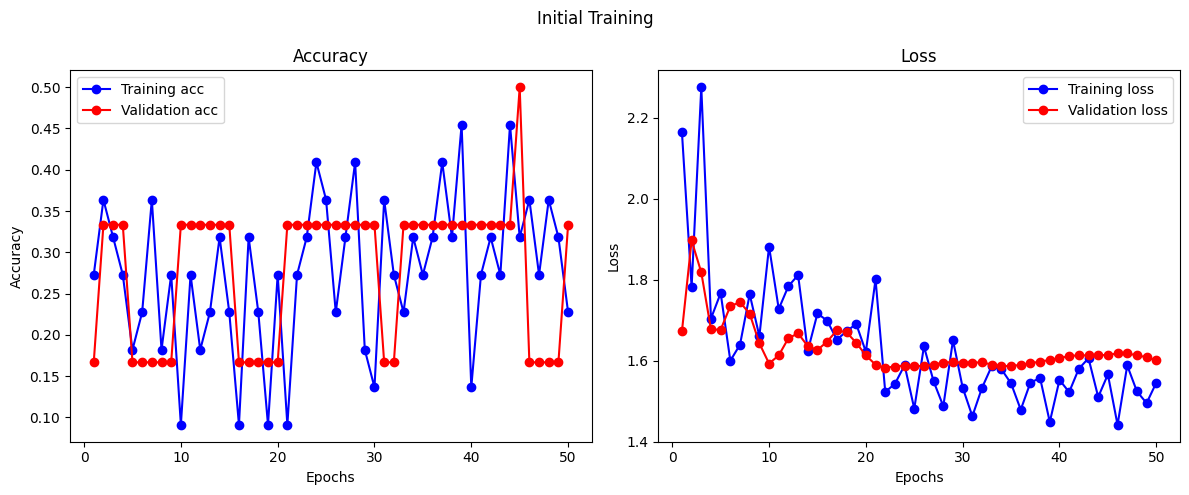

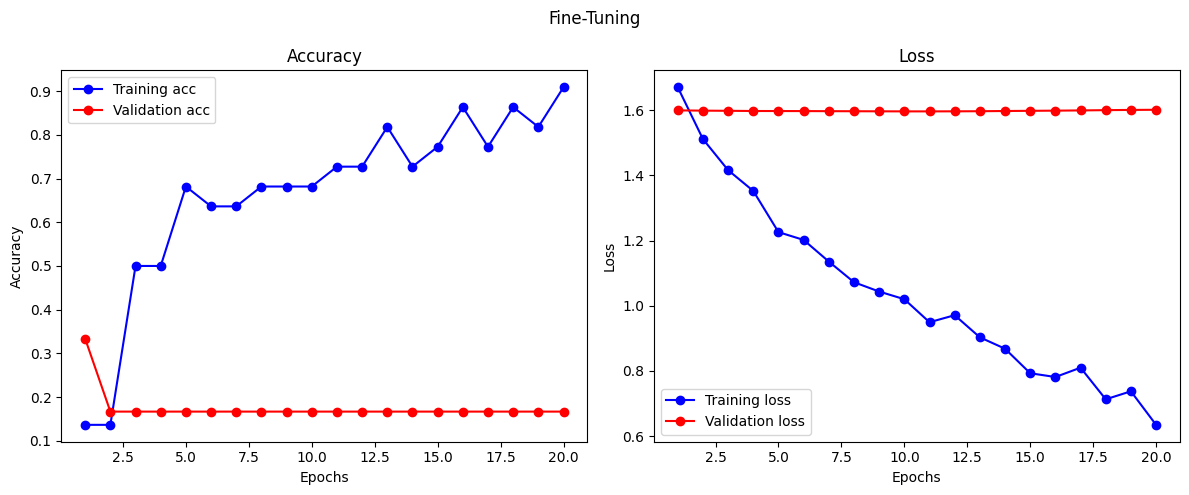

In [6]:
# =====================
# Plot training history
# =====================

print("== Plotting training histories ==")
plot_training_history(history, title="Initial Training")
plot_training_history(ft_history, title="Fine-Tuning")


== Confusion matrix for base model ==


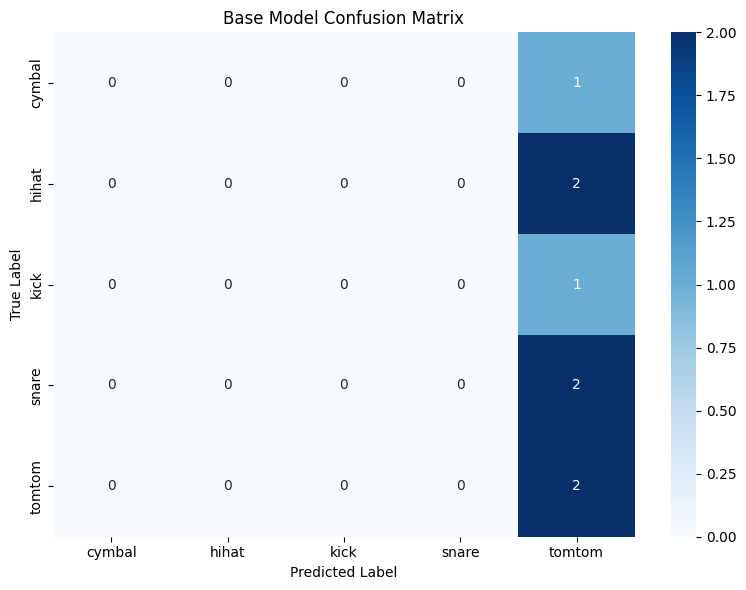

== Confusion matrix for fine-tuned model ==


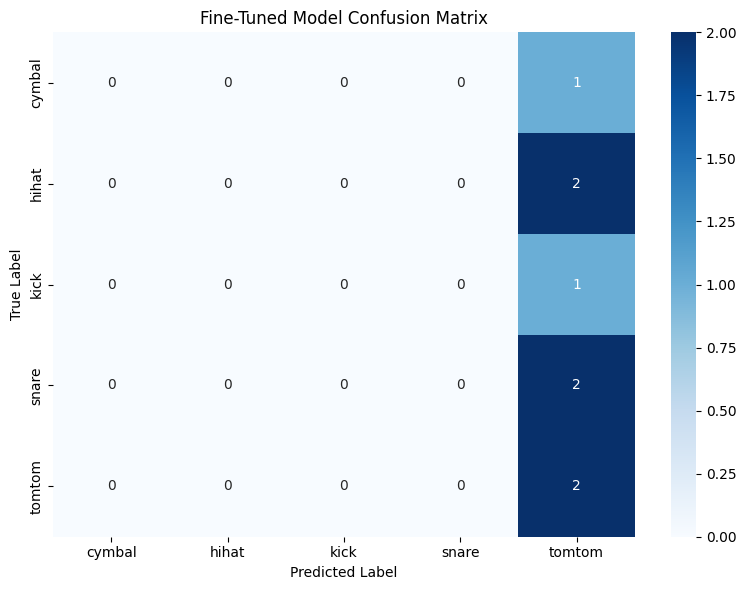

In [7]:
# =====================
# Plot Confusion Matrix
# =====================

# Plot confusion matrix for base model
print("== Confusion matrix for base model ==")
plot_confusion_matrix(true_classes, predictions, class_indices, title="Base Model Confusion Matrix")

# Plot confusion matrix for fine-tuned model
print("== Confusion matrix for fine-tuned model ==")
plot_confusion_matrix(ft_true_classes, ft_predictions, class_indices, title="Fine-Tuned Model Confusion Matrix")
